<h1 style="background-color:#7AE7C7;text-align:center">GitHub Bug Prediction Model using BERT</h1>

In this notebook, I have implemented a BERT-based model that can classify a GitHub title and body into three categories: Bugs, Features and Questions. Here, I have employed BERT-base uncased model for performing the classification task. The notebook has been organized as follows:

1. Exploratory Data Analysis
     * Most common terms employed when referring to a GitHub *Bug*
     * Most common terms employed when referring to a GitHub *feature*
     * Most common terms employed when referring to a GitHub *questions*

2. Model Architecture
3. Preprocessing GitHub messages
4. Importing Transformer, PyTorch library and constructing the BERT model.
5. Class definition of GitHub messages
6. Creating training, testing and validation data
7. Creating data loaders
8. Class for BERT-based GitHub Bug Predictor model
9. Training the model
10. Results and evaluation
11. Future improvements
12. References

<h1 style="background-color:#7AE7C7;text-align:center">Exploratory Data Analysis</h1>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/github-bugs-prediction/embold_train.json
/kaggle/input/github-bugs-prediction/sample submission.csv
/kaggle/input/github-bugs-prediction/embold_test.json
/kaggle/input/github-bugs-prediction/embold_train_extra.json


In [2]:
# creating a dataframe out of embol_train.json
df = pd.read_json('/kaggle/input/github-bugs-prediction/embold_train.json')
df['combined'] = df['title']+'. '+df['body']
df.head()

,title,body,label,combined
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll. a y-zoom on the piano roll ...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection. ! screenshot from...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature. hi,\r \r great job so far..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs. i think we...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...


In [3]:
df_bug = df[df['label']==0]
df_feature = df[df['label']==1]
df_question = df[df['label']==2]

In [4]:
import nltk
import re
import string


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [5]:
from string import punctuation
from nltk.corpus import stopwords

def punctuation_stopwords_removal(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_git_text

In [6]:
from collections import Counter
import plotly.express as px

def plot_most_common_words(df_category, category):
    df_category['combined'] = df_category['combined'].apply(lambda x: x.replace("\\r", ""))
    df_category['combined'] = df_category['combined'].apply(lambda x: clean_text(x))
    
    df_category["combined"] = df_category["combined"].apply(punctuation_stopwords_removal)
    
    word_list = []
    
    for i, j in df_category.iterrows():
        for word in j['combined']:
            word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used while refering to a GitHub {}'.format(category),
                       color_discrete_sequence=['#843B62'] )
    fig.show()

In [7]:
# taking only a subset; since huge dataset
plot_most_common_words(df_bug[:10000], 'Bugs 🕷')

In [8]:
plot_most_common_words(df_feature[:7000], 'Features 💡')

In [9]:
plot_most_common_words(df_question[:7000], 'Questions ⁉️')

<h1 style="background-color:#7AE7C7;text-align:center">Model Architecture</h1>

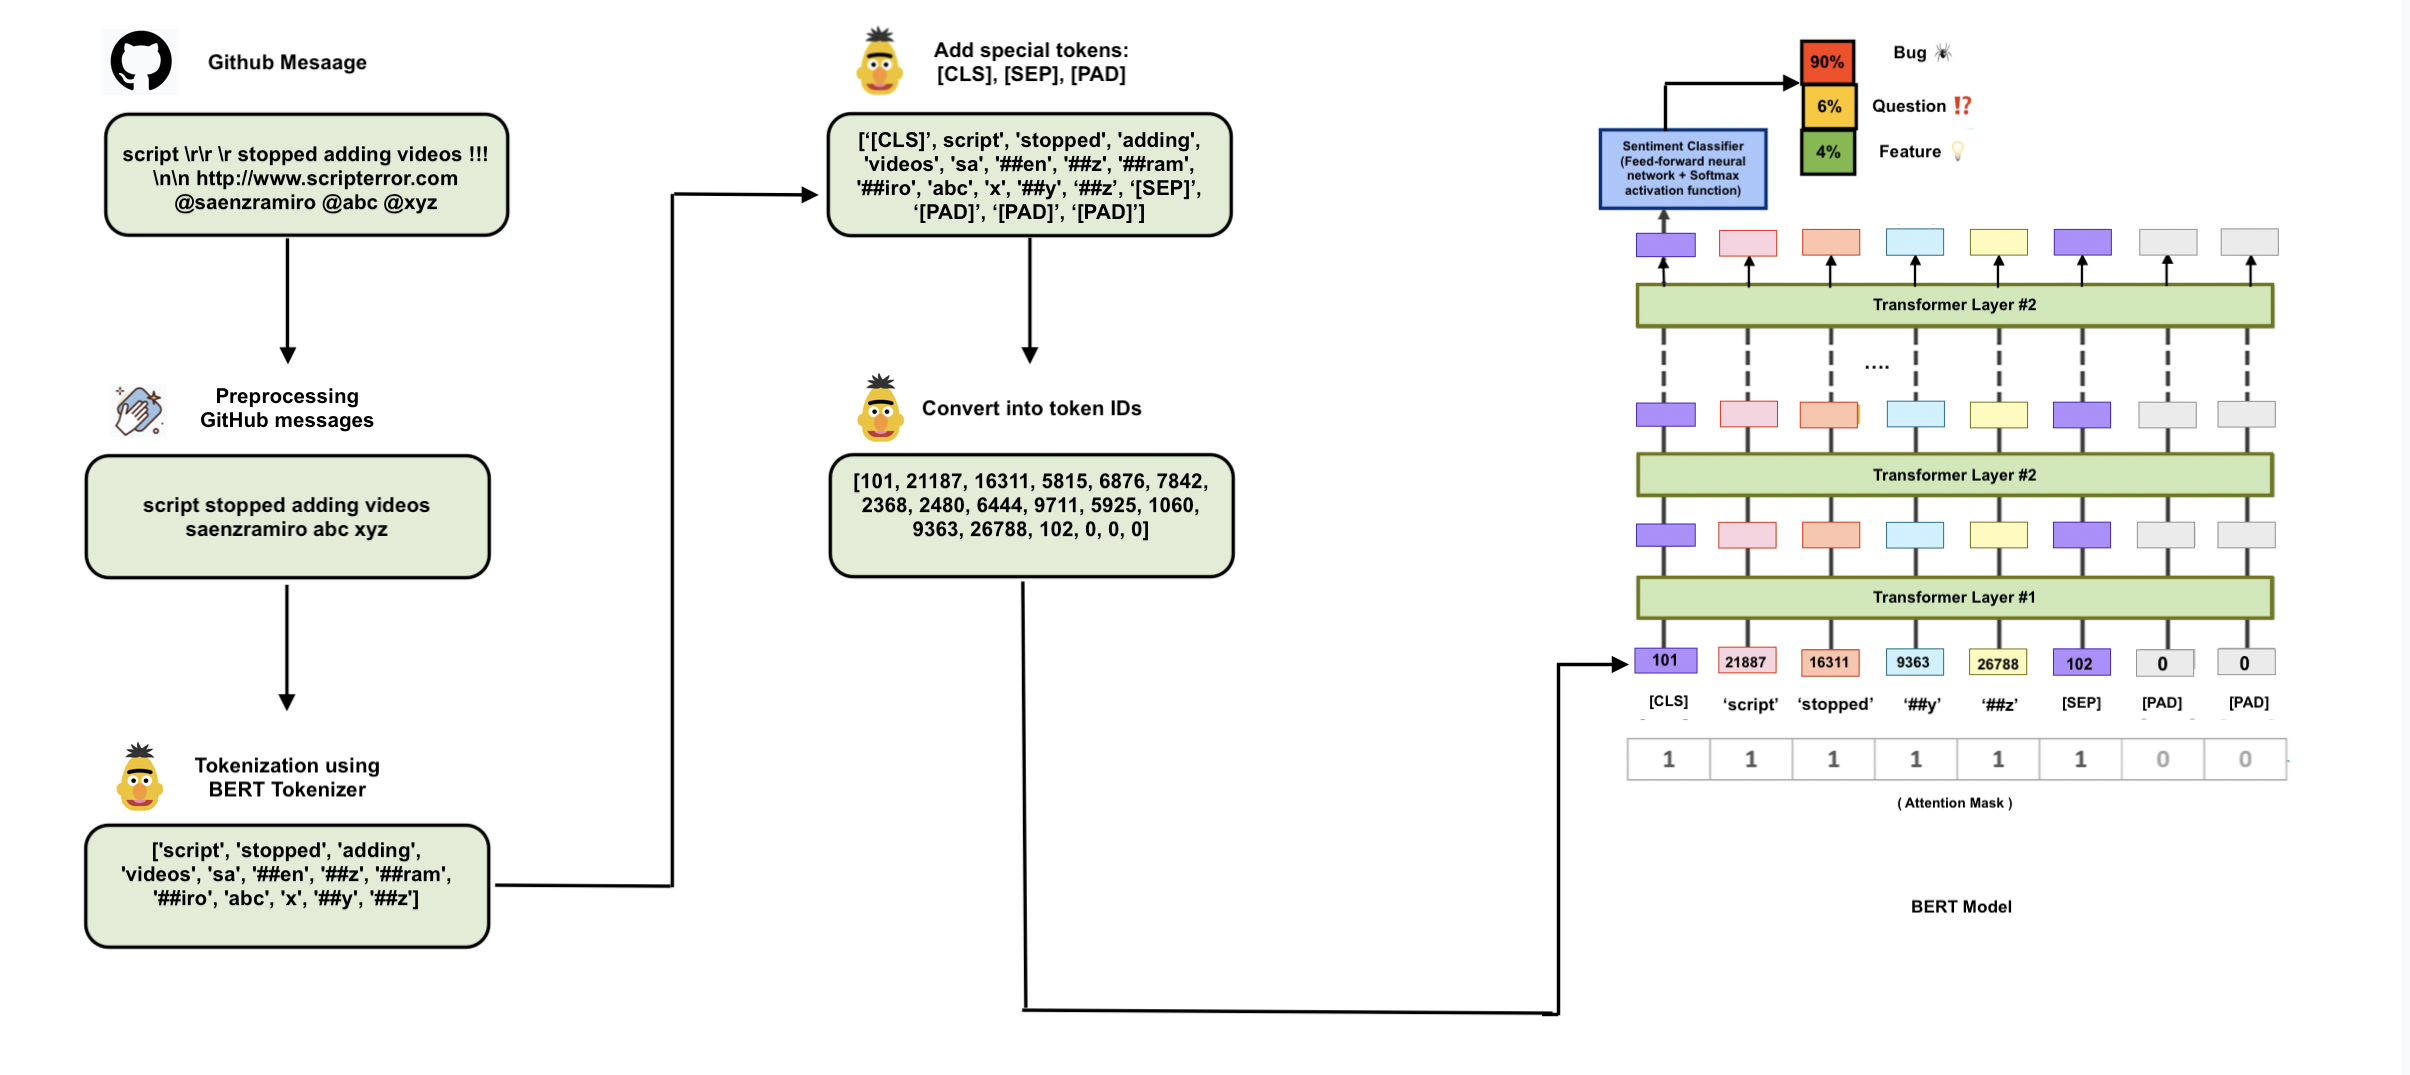

<h1 style="background-color:#7AE7C7;text-align:center">Preprocessing GitHub Messages</h1>

In [10]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
df['combined'] = df['combined'].apply(lambda x: x.replace("\\r", ""))
df['combined'] = df['combined'].apply(lambda x: clean_text(x))
df.head()

,title,body,label,combined
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


In [11]:
df.drop(['title', 'body'], axis=1, inplace=True)
df.head()

,label,combined
0,1,yzoom piano roll a yzoom on the piano roll wou...
1,0,buggy behavior in selection screenshot from ...
2,1,auto update feature hi great job so far saenz...
3,1,filter out noisy endpoints in logs i think we ...
4,0,enable pid on pid off alarm actions for expe...


<h1 style="background-color:#7AE7C7;text-align:center">Importing Transformer, PyTorch Libraries and constructing BERT model</h1>

In [12]:
import torch
import torch.nn as nn

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [13]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
#loading our BERT model
BERT_UNCASED = '/kaggle/input/bert-base-uncased'

In [16]:
#loading the pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_UNCASED)

In [17]:
# some basic operations to understand how BERT converts a sentence into tokens and then into IDs
sample_body = 'script stopped adding videos saenzramiro abc xyz'
tokens = tokenizer.tokenize(sample_body)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_body}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: script stopped adding videos saenzramiro abc xyz
   Tokens: ['script', 'stopped', 'adding', 'videos', 'sa', '##en', '##z', '##ram', '##iro', 'abc', 'x', '##y', '##z']
Token IDs: [5896, 3030, 5815, 6876, 7842, 2368, 2480, 6444, 9711, 5925, 1060, 2100, 2480]


In [18]:
# using encode_plus to add special tokens : [CLS]:101, [SEP]:102, [PAD]:0
encodings = tokenizer.encode_plus(
            sample_body,
            max_length=32,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
)

encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
print('Input IDs : {}'.format(encodings['input_ids'][0]))
print('\nAttention Mask : {}'.format(encodings['attention_mask'][0]))

Input IDs : tensor([ 101, 5896, 3030, 5815, 6876, 7842, 2368, 2480, 6444, 9711, 5925, 1060,
        2100, 2480,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Attention Mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [20]:
MAX_LENGTH = 512

<h1 style="background-color:#7AE7C7;text-align:center">Class for our GitHub messages</h1>

In [21]:
class GitHubCommitMessages(Dataset):
    
    def __init__(self, commit_message, label, tokenizer, max_len):
        self.commit_message = commit_message
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.commit_message)
    
    def __getitem__(self, item):
        commit_message = str(self.commit_message[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        commit_message,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'commit_message': commit_message,
         'input_ids': encoding['input_ids'],
         'attention_mask': encoding['attention_mask'],
         'label': torch.tensor(label, dtype=torch.long)
          }

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df.head()

,label,combined
0,1,yzoom piano roll a yzoom on the piano roll wou...
1,0,buggy behavior in selection screenshot from ...
2,1,auto update feature hi great job so far saenz...
3,1,filter out noisy endpoints in logs i think we ...
4,0,enable pid on pid off alarm actions for expe...


<h1 style="background-color:#7AE7C7;text-align:center">Creating training, testing and validation data</h1>

In [24]:
df = df[:2000]

In [25]:
df.shape

(2000, 2)

In [26]:
training_data, testing_data = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

testing_data, validation_data = train_test_split(
    testing_data,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [27]:
training_data.shape, testing_data.shape, validation_data.shape

((1800, 2), (100, 2), (100, 2))

<h1 style="background-color:#7AE7C7;text-align:center">Creating data loaders</h1>

In [28]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = GitHubCommitMessages(commit_message=data.combined.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)


BATCH_SIZE = 16
train_data_loader = create_data_loader(training_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [29]:
df = next(iter(train_data_loader))
df.keys()

dict_keys(['commit_message', 'input_ids', 'attention_mask', 'label'])

In [30]:
df['input_ids'].squeeze().shape, df['attention_mask'].squeeze().shape, df['label'].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

In [31]:
print('commit_message  : ', df['commit_message'][0])
print('input_ids : ', df['input_ids'].squeeze()[0])
print('attention_mask : ', df['attention_mask'].squeeze()[0])
print('label : ', df['label'][0])

commit_message  :  how to use html instead of twig  for a template file extension  thanks  jason
input_ids :  tensor([  101,  2129,  2000,  2224, 16129,  2612,  1997,  1056, 16279,  2005,
         1037, 23561,  5371,  5331,  4283,  4463,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

In [32]:
bert_model = BertModel.from_pretrained(BERT_UNCASED)

In [33]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encodings['input_ids'],
  attention_mask=encodings['attention_mask']
)

In [34]:
last_hidden_state.shape, pooled_output.shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

<h1 style="background-color:#7AE7C7;text-align:center">Class for our BERT-based GitHub Bug Predictor model</h1>

In [35]:
class BugPredictor(nn.Module):
    
    def __init__(self, n_classes):
        super(BugPredictor, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_UNCASED)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)
        

In [36]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
class_names = [0, 1, 2]
bug_predictor_model = BugPredictor(len(class_names))
bug_predictor_model = bug_predictor_model.to(device)

<h1 style="background-color:#7AE7C7;text-align:center">Training the model</h1>

In [37]:
EPOCHS = 5

optimizer = AdamW(bug_predictor_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [38]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].squeeze().to(device)
        attention_mask = d['attention_mask'].squeeze().to(device)
        targets = d['label'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].squeeze().to(device)
            attention_mask = d['attention_mask'].squeeze().to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [40]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
    
    train_acc, train_loss = train_model(bug_predictor_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))
    
    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(bug_predictor_model, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(bug_predictor_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc
    

EPOCH 1/5
----------
Train loss : 0.7101824076566021 accuracy : 0.7205555555555555
Validation loss : 0.47729658229010447 accuracy : 0.81
Saving the best model ...
EPOCH 2/5
----------
Train loss : 0.42905161519889284 accuracy : 0.8616666666666667
Validation loss : 0.41250266241175787 accuracy : 0.84
Saving the best model ...
EPOCH 3/5
----------
Train loss : 0.2697599794122234 accuracy : 0.9205555555555556
Validation loss : 0.41229815648070406 accuracy : 0.85
Saving the best model ...
EPOCH 4/5
----------
Train loss : 0.18322904646990046 accuracy : 0.9494444444444444
Validation loss : 0.556763998365828 accuracy : 0.84
EPOCH 5/5
----------
Train loss : 0.10821816483842192 accuracy : 0.9722222222222222
Validation loss : 0.5288413098481085 accuracy : 0.86
Saving the best model ...
CPU times: user 8min 5s, sys: 5.08 s, total: 8min 10s
Wall time: 8min 23s


<h1 style="background-color:#7AE7C7;text-align:center">Results and Evaluation</h1>

<h4>So our BERT-based GitHub bug predictor model achieved training accuracy of 96.5% and validation accuracy of 85%. Let us see some sample Git messages and categorize them into bugs, features and questions based on our model!<h4>

In [41]:
sample_bug_message = "Script stopped adding video's. A recent change in the youtube layout broke the script. Probably caused by element names being altered."

In [42]:
class_names = ['bug', 'feature', 'question']

In [43]:
def predict_git_category(sample_message, model):
    encoded_message = tokenizer.encode_plus(sample_bug_message, max_length=MAX_LENGTH, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
        
    return class_names[prediction_idx]


In [44]:
print('Sample bug message : ', sample_bug_message)
print('Predicted GitHub Category : ', predict_git_category(sample_bug_message, bug_predictor_model))

Sample bug message :  Script stopped adding video's. A recent change in the youtube layout broke the script. Probably caused by element names being altered.
Predicted GitHub Category :  bug


<h1 style="background-color:#7AE7C7;text-align:center">Future Improvements</h1>

1. Due to low computational resources,  was not able to leverage the entire dataset for training the BERT model. 
2. I still need to employ BERT large model to test its accuracy on GitHub message classification use-case.
3. The model was trained on only 5 epochs, which I feel can be increased.
4. The dataset provided has rich textual information. This can be leveraged for other NLP tasks such as natural language generation. 

<h1 style="background-color:#7AE7C7;text-align:center">References</h1>

1. https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
2. https://huggingface.co/transformers/
3. http://jalammar.github.io